# Problem Description

![Caption](files/img/ContinuousNet.png)


The network defined above has the corresponding continuous random variables.
Below are the distributions of the nodes.
* A: Exponential, $\lambda = 2$
$$ A(a) = \lambda e^{- \lambda x} $$
* B: Uniform 
$$
B(b) =\begin{cases}
    \frac{1}{4}, & \text{if $0 < b < 4$}\\
    0, & \text{otherwise}
  \end{cases}$$
* C: Normal, Mean is B, Standard Deviation is A
$$  C(c)=\frac{1}{\sqrt{2\pi a^2}}e^{-\frac{(c-b)^2}{2a^2}} $$
* D: Normal, Mean C, Standard Deviation of 2
$$  D(d)=\frac{1}{\sqrt{8\pi}}e^{-\frac{(d-c)^2}{8}} $$
* E: Normal, Mean 0, Standard Deviation of C
$$  E(x)=\frac{1}{\sqrt{2\pi c^2}}e^{-\frac{x^2}{2c^2}} $$

In [1]:
import numpy, pymc3, theano

nobserve = 1000

obsdata = theano.shared(numpy.zeros(nobserve))

with pymc3.Model() as model:
    a = pymc3.Exponential('a', lam=2.)
    b = pymc3.Uniform('b', lower=0, upper=4)
    c = pymc3.Normal('c', mu=b, sd=a)
    d = pymc3.Normal('d', mu=c, sd=2)
    e = pymc3.Normal('e', mu=0, sd=c)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\users\rahul\appdata\local\programs\python\python35\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
c:\users\rahul\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\users\rahul\appdata\local\programs\python\python35\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [e, d, c, b_interval__, a_log__]
There were 3601 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3467 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4374 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6899649081157293, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3744 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples i

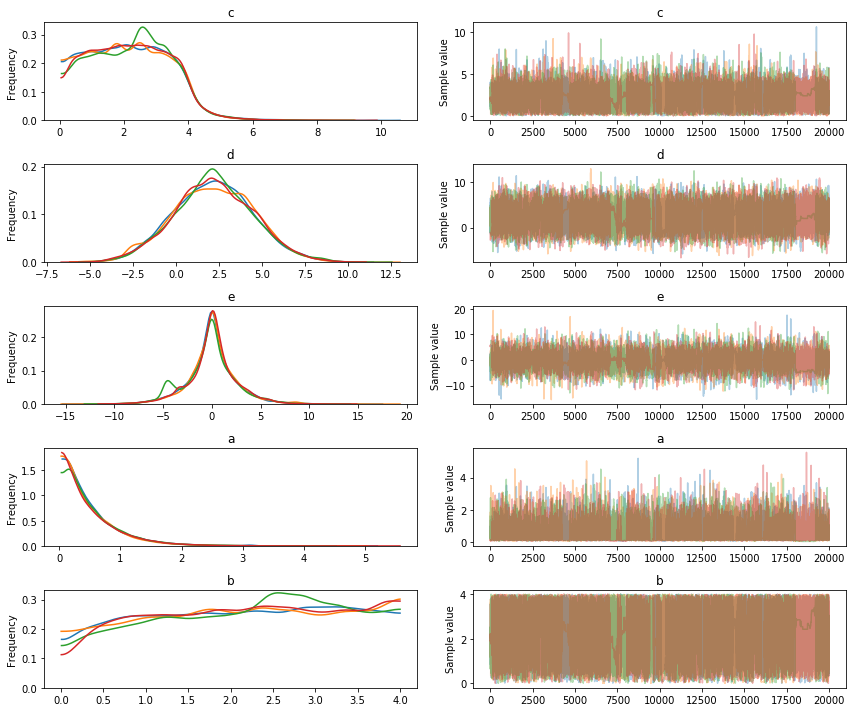

In [6]:
%matplotlib inline

nTrials = 20000

with model:
    trace = pymc3.sample(nTrials)
    pymc3.traceplot(trace)


Here, we modify the function created before to check for values within a range:

In [7]:
# Functions changed to allow for different conditions and updated for continuous variables
def calcCondProb(trace, event, cond):
    for k, v in cond.items():
        # If the value for the sample is below our upper bound, add it to the trace
        trace = [sample for sample in trace if sample[k] < v]
    # Get number of samples that match the condition
    numSamples = len(trace)
    if numSamples == 0:
        return -1
    for k, v in event.items():
        # If the values of the event are met, find those samples and add it to the trace
        trace = [sample for sample in trace if sample[k] < v]
    return len(trace)/numSamples

In [45]:
# Function modified to allow for different checks for conditions and events
def calcCondProb2(trace, event, cond):
    for k, v in cond.items():
        # If the value for the sample is below our upper bound, add it to the trace
        trace = [sample for sample in trace if sample[k] > v]
    # Get number of samples that match the condition
    numSamples = len(trace)
    if numSamples == 0:
        return -1
    for k, v in event.items():
        # If the values of the event are met, find those samples and add it to the trace
        trace = [sample for sample in trace if sample[k] < v]
    return len(trace)/numSamples

In [78]:
# Function modified to allow for different checks for conditions and events
# Used to do a check for a small area, posterior of normal
def calcCondProb3(trace, event, cond, range):
    for k, v in cond.items():
        # If the value for the sample is below our upper bound, add it to the trace
        trace = [sample for sample in trace if (sample[k] <  range + v and sample[k] <  v - range)]
    # Get number of samples that match the condition
    numSamples = len(trace)
    if numSamples == 0:
        return -1
    for k, v in event.items():
        # If the values of the event are met, find those samples and add it to the trace
        trace = [sample for sample in trace if sample[k] < v]
    return len(trace)/numSamples

### Sample output values
Below, we run some tests on the values we obtained from running 20,000 samples. 

In [51]:
print('P ( A < .5)', (calcCondProb(trace, {'a': .5}, {})))
print('P ( B < 2)', (calcCondProb(trace, {'b': 2}, {})))
print('P ( C < 2)', (calcCondProb(trace, {'c': 2}, {})))
print('P ( D < 2)', (calcCondProb(trace, {'d': 2}, {})))
print('P ( E < 0)', (calcCondProb(trace, {'e': 0}, {})))
print('P ( E < 1, D < 0)', (calcCondProb(trace, {'e': 1, 'd': 0}, {})))
print('P ( A < 2, E < 1, D < 0)', (calcCondProb(trace, {'e': 1, 'd': 0, 'a': 2}, {})))
print('P ( A < 2 | D < 0, E < 1)', (calcCondProb(trace, {'a': 2}, {'d': 0, 'e' : 1})))
print('P ( A < .5 | D < 3, E < -2)', (calcCondProb(trace, {'a': .5}, {'d': 3, 'e' : -2})))
print('P ( A < 1 | E < 0)', calcCondProb(trace, {'a': 1}, {'e': 0}))
print('P ( A > 1 | D < -2.5)', (1 - calcCondProb(trace, {'a': 1}, {'d': -2.5})))
print('P ( A < 2 | D < 0)', (calcCondProb(trace, {'a': 2}, {'d': 0})))
print('P ( A < 2 | D < 0)', (calcCondProb(trace, {'a': 2}, {'d': 0})))

print('P ( C > 5 | D > 4)', (1 - calcCondProb2(trace, {'c': 5}, {'d': 4})))
print('P ( C > 3 | D > 4)', (1 - calcCondProb2(trace, {'c': 3}, {'d': 4})))
print('P ( C > 3)', (1 - calcCondProb2(trace, {'c': 3}, {})))

P ( A < .5) 0.61
P ( B < 2) 0.4544
P ( C < 2) 0.4516
P ( D < 2) 0.4832
P ( E < 0) 0.4826
P ( E < 1, D < 0) 0.13675
P ( A < 2, E < 1, D < 0) 0.135
P ( A < 2 | D < 0, E < 1) 0.9872029250457038
P ( A < .5 | D < 3, E < -2) 0.6603351955307263
P ( A < 1 | E < 0) 0.8553667633651056
P ( A > 1 | D < -2.5) 0.12761506276150625
P ( A < 2 | D < 0) 0.9879482657260436
P ( A < 2 | D < 0) 0.9879482657260436
P ( C > 5 | D > 4) 0.042259990813045434
P ( C > 3 | D > 4) 0.5408819476343592
P ( C > 3) 0.28480000000000005


Below are some test values with ranges input to determine the range of values to be accepted. I used this for some examples and for the posterior calculation, to give the expected value

In [81]:
print('P ( C > 3 | 3.9 < D < 4.1)', (1 - calcCondProb3(trace, {'c': 3}, {'d': 4}, .1)))
print('P ( C > 3 | 4 < D < 16)', (1 - calcCondProb3(trace, {'c': 3}, {'d': 10}, 6)))


P ( C > 3 | 3.9 < D < 4.1) 0.2105673114371024
P ( C > 3 | 4 < D < 16) 0.21353700626358174


### Posterior Calculations

In order to find the posterior distribution, we must first start with the PDFs of each node. 
* A: Exponential, $\lambda = 2$
$$ P(a) = \lambda e^{- \lambda x} $$
* B: Uniform 
$$
P(b) =\begin{cases}
    \frac{1}{4}, & \text{if $0 < b < 4$}\\
    0, & \text{otherwise}
  \end{cases}$$
* C: Normal, Mean is B, Standard Deviation is A
$$  P(c| a, b)=\frac{1}{\sqrt{2\pi a^2}}e^{-\frac{(c-b)^2}{2a^2}} $$
* D: Normal, Mean C, Standard Deviation of 2
$$  P(d|c)=\frac{1}{\sqrt{8\pi}}e^{-\frac{(d-c)^2}{8}} $$
* E: Normal, Mean 0, Standard Deviation of C
$$  P(x|c)=\frac{1}{\sqrt{2\pi c^2}}e^{-\frac{x^2}{2c^2}} $$

Of course for this problem, C will always be represented better than A or B, as D and E are directly related to C, while C filters out the values obtained from A and B. Thus you will see more accurate results from trying to predict C.

We can test out P( C > 3 | D > 4)
We know the mean of D is C, thus we can use the base posterior of trying to find the mean based upon the output of a normal dsitribution, as we have the standard deviation known. 

We know that this is the probability distribution of P(D | C), as shown above.
$$  P(d | c)=\frac{1}{\sqrt{8\pi}}e^{-\frac{(d-c)^2}{8}} $$
We can also say that D and C are noth sets of data, and thus both are sets with the same cardinality, as the distribution of a single pair from each will be the same as the function above, while the distribution of the two sets is the same, but we replace d and c with the **d** and **c** instead, and divide the standard deviation by the cardinality.
$$  P(d | c)=\alpha e^{-\frac{(d-c)^2}{8}} $$
Since our prior for D is always 1, $ P(c|d) $ is then proportional to the above equation.
$$  P(c|d)=\alpha e^{-\frac{(d-c)^2}{8}} $$
We can see from looking at the distribution above, and notice that the posterior distribution of C is actually a normal distribution with a mean of d, and a standard deviation of 2. Using this, we can then calculate $ P( C > 3 | D > 4) $. Doing the calculation where the mean of a distribution is a range is difficult, but doing individual probabilities is easy. For example, we get $ P( C > 3 | D = 4) = .3085 $, and using this technique, we can then go along and get values at intervals, then average them together to get a reflective distribution, essentially reflecting an integral over the range in question. This average we expect to be around the value we obtained earlier through our trials, and is not calculated due to the difficulty of doing so. 